In [1]:
import torch
device = torch.device(torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu')\

device

device(type='cuda')

In [2]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics import Accuracy, F1Score, Precision, Recall, ConfusionMatrix
from seaborn import heatmap



class FoodDataset(torch.utils.data.Dataset):
    def __init__(self, class_list, image_folder):
        self.file_class = class_list
        self.image_folder = image_folder

    def __len__(self):
        return len(self.file_class)
    
    def __getitem__(self, idx):
        image_name = self.file_class.iloc[idx, 0]
        image_path = f"{self.image_folder}/{image_name}"
        image = Image.open(image_path).convert('RGB')

        label = self.file_class.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)

        preprocessing = v2.Compose([
            v2.Resize((128, 128)),
            v2.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
            v2.RandomHorizontalFlip(p=0.5),
            v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            v2.RandomGrayscale(p=0.1),
            v2.RandomErasing(p=0.3),
            v2.ToTensor(),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]).to(device)

        image = preprocessing(image)

        return image, label

# Dataset split

In [3]:
train_image_label = pd.read_csv('annot/train_info.csv', names=['image_name', 'label'])

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(train_image_label, train_size = 0.8, test_size=0.2, random_state=42)

reduced_train_df = []
for i in range(251):
    if train_df[train_df['label'] == i].shape[0] > 350:
        # If there are more than 200 samples, sample 100
        reduced_train_df.append(train_df[train_df['label'] == i].sample(350, random_state=42))
    else:
        # If there are less than 200 samples, take all available samples
        reduced_train_df.append(train_df[train_df['label'] == i])

reduced_train_df = pd.concat(reduced_train_df, ignore_index=True)

reduced_val_df = []
for i in range(251):
    if val_df[val_df['label'] == i].shape[0] > 30:
        # If there are more than 30 samples, sample 100
        reduced_val_df.append(val_df[val_df['label'] == i].sample(30, random_state=42))
    else:
        # If there are less than 30 samples, take all available samples
        reduced_val_df.append(val_df[val_df['label'] == i])

reduced_val_df = pd.concat(reduced_val_df, ignore_index=True)

c:\Users\eliau\OneDrive\Desktop\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2102921..2.64].


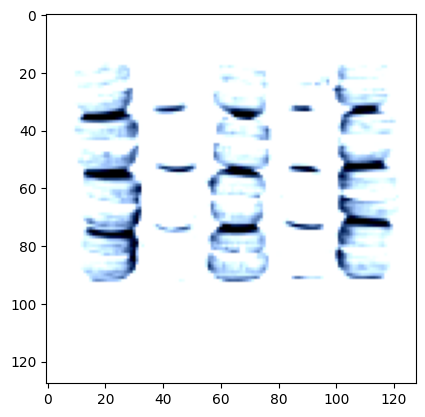

In [4]:
train_dataset = FoodDataset(reduced_train_df, 'train/train_set')
image_train, label_train = train_dataset.__getitem__(0)

plt.imshow(image_train.permute(1, 2, 0).numpy())

val_dataset = FoodDataset(reduced_val_df, 'train/train_set')
image_val, label_val = val_dataset.__getitem__(0)

In [5]:
test_df = pd.read_csv('annot/val_info.csv')

test_dataset = FoodDataset(test_df, 'val/val_set')
test_dataset.__getitem__(0)

c:\Users\eliau\OneDrive\Desktop\FoodClassification\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


(tensor([[[-1.1589, -1.1247, -1.0904,  ...,  0.7419,  0.7248,  0.6906],
          [-1.2274, -1.2445, -1.2788,  ...,  0.7419,  0.7248,  0.7077],
          [-1.4158, -1.4329, -1.4158,  ...,  0.7419,  0.7248,  0.7077],
          ...,
          [ 0.3138,  0.2967,  0.2453,  ...,  0.2796,  0.3652,  0.3823],
          [ 0.3309,  0.2624,  0.2111,  ...,  0.2453,  0.3652,  0.3823],
          [ 0.3309,  0.2282,  0.1768,  ...,  0.3309,  0.3652,  0.3652]],
 
         [[-0.9328, -0.8978, -0.8452,  ...,  0.8354,  0.8179,  0.8004],
          [-0.9853, -1.0203, -1.0553,  ...,  0.8004,  0.8179,  0.8004],
          [-1.2129, -1.2304, -1.2129,  ...,  0.8004,  0.8179,  0.8004],
          ...,
          [ 0.3803,  0.2927,  0.2577,  ...,  0.2577,  0.4153,  0.4678],
          [ 0.3803,  0.2752,  0.2227,  ...,  0.2577,  0.3978,  0.4678],
          [ 0.3978,  0.2577,  0.1877,  ...,  0.3627,  0.4328,  0.4503]],
 
         [[-0.4450, -0.4101, -0.3753,  ...,  0.9842,  0.9842,  0.9668],
          [-0.5321, -0.5495,

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)  # pt = softmax prob of correct class
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()


criterion = FocalLoss(alpha=0.25, gamma=2).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.93277305..1.6988237].


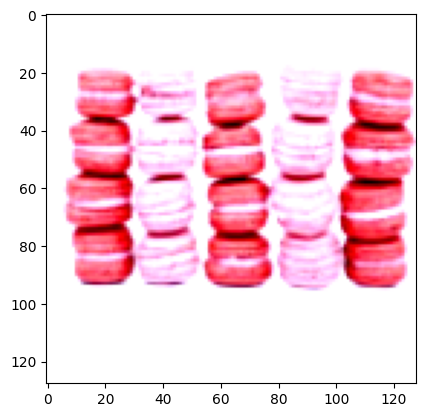

In [8]:
train_dataset = FoodDataset(reduced_train_df, 'train/train_set')
image_train, label_train = train_dataset.__getitem__(0)

plt.imshow(image_train.permute(1, 2, 0).numpy())

val_dataset = FoodDataset(reduced_val_df, 'train/train_set')
image_val, label_val = val_dataset.__getitem__(0)

In [9]:
import torch
import torch.nn as nn

# Optional: Squeeze-and-Excitation block to enhance channels
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.SiLU(),  # better than ReLU
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.shape
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# Depthwise separable residual block with SE and SiLU
class ResidualDWBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_c, in_c, kernel_size=3, stride=stride, padding=1, groups=in_c),
            nn.BatchNorm2d(in_c),
            nn.SiLU(),
            nn.Conv2d(in_c, out_c, kernel_size=1),
            nn.BatchNorm2d(out_c),
            SEBlock(out_c)
        )
        self.skip = nn.Identity()
        if in_c != out_c or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_c)
            )
        self.act = nn.SiLU()

    def forward(self, x):
        return self.act(self.main(x) + self.skip(x))

# The full CNN model
class ResidualFoodCNN(nn.Module):
    def __init__(self, num_classes=251):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU()
        )

        self.layer1 = nn.Sequential(
            ResidualDWBlock(64, 128, stride=2),
            ResidualDWBlock(128, 128)
        )
        self.layer2 = nn.Sequential(
            ResidualDWBlock(128, 256, stride=2),
            ResidualDWBlock(256, 256)
        )
        self.layer3 = nn.Sequential(
            ResidualDWBlock(256, 512, stride=2),
            ResidualDWBlock(512, 512)
        )
        self.layer4 = nn.Sequential(
            ResidualDWBlock(512, 512),  # No further downsampling
            ResidualDWBlock(512, 512)
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(512, 1024),
            nn.SiLU(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


In [10]:
cnn = ResidualFoodCNN(num_classes=251)
print(f"Total params: {sum(p.numel() for p in cnn.parameters() if p.requires_grad):,}")
cnn.to(device)

Total params: 2,191,019


ResidualFoodCNN(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (layer1): Sequential(
    (0): ResidualDWBlock(
      (main): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): SEBlock(
          (pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=128, out_features=8, bias=True)
            (1): SiLU()
            (2): Linear(in_features=8, out_features=128, bias=True)
            (3): Sigmoid()
          )
        )
      )
      (skip): Sequentia

In [41]:
num_epochs = 50
optimizer = torch.optim.AdamW(cnn.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

shutil.rmtree('runs/food_classification', ignore_errors=True)
writer = SummaryWriter('runs/food_classification')

training_accuracy = torchmetrics.Accuracy(num_classes=251, task='multiclass').to(device)
validation_accuracy = torchmetrics.Accuracy(num_classes=251, task='multiclass').to(device)
criterion = nn.CrossEntropyLoss().to(device)

training_per_batch_losses = []
training_per_batch_accuracies = []
validation_per_batch_losses = []
validation_per_batch_accuracies = []

for epoch in range(num_epochs):


    cnn.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(tqdm(train_dataloader)):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = cnn(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        training_per_batch_losses.append(loss.item())
        training_per_batch_accuracies.append(training_accuracy(outputs, labels).item())

        # Logging
        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_dataloader) + i)

    # Compute and print epoch-level training metrics
    avg_train_loss = sum(training_per_batch_losses[-len(train_dataloader):]) / len(train_dataloader)
    avg_train_acc = sum(training_per_batch_accuracies[-len(train_dataloader):]) / len(train_dataloader)
    print(f"[Epoch {epoch+1}] Training Loss: {avg_train_loss:.4f} | Training Accuracy: {avg_train_acc*100:.2f}%")

    # 🔍 Validation
    cnn.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            validation_per_batch_losses.append(loss.item())
            validation_per_batch_accuracies.append(validation_accuracy(outputs, labels).item())

    avg_val_loss = sum(validation_per_batch_losses[-len(val_dataloader):]) / len(val_dataloader)
    avg_val_acc = sum(validation_per_batch_accuracies[-len(val_dataloader):]) / len(val_dataloader)
    print(f"[Epoch {epoch+1}] Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_acc*100:.2f}%")

    scheduler.step(avg_val_loss)


100%|██████████| 782/782 [12:07<00:00,  1.07it/s]


[Epoch 1] Training Loss: 5.0124 | Training Accuracy: 3.58%


100%|██████████| 118/118 [01:35<00:00,  1.23it/s]


[Epoch 1] Validation Loss: 4.6262 | Validation Accuracy: 6.76%


100%|██████████| 782/782 [05:02<00:00,  2.59it/s]


[Epoch 2] Training Loss: 4.4940 | Training Accuracy: 8.59%


100%|██████████| 118/118 [00:35<00:00,  3.28it/s]


[Epoch 2] Validation Loss: 4.3335 | Validation Accuracy: 10.75%


100%|██████████| 782/782 [04:57<00:00,  2.63it/s]


[Epoch 3] Training Loss: 4.1698 | Training Accuracy: 12.97%


100%|██████████| 118/118 [00:34<00:00,  3.44it/s]


[Epoch 3] Validation Loss: 4.0147 | Validation Accuracy: 15.18%


100%|██████████| 782/782 [04:53<00:00,  2.67it/s]


[Epoch 4] Training Loss: 3.9034 | Training Accuracy: 17.05%


100%|██████████| 118/118 [00:33<00:00,  3.49it/s]


[Epoch 4] Validation Loss: 3.8075 | Validation Accuracy: 17.95%


100%|██████████| 782/782 [04:52<00:00,  2.67it/s]


[Epoch 5] Training Loss: 3.6864 | Training Accuracy: 20.31%


100%|██████████| 118/118 [00:34<00:00,  3.46it/s]


[Epoch 5] Validation Loss: 3.6259 | Validation Accuracy: 21.78%


100%|██████████| 782/782 [04:51<00:00,  2.68it/s]


[Epoch 6] Training Loss: 3.4867 | Training Accuracy: 23.47%


100%|██████████| 118/118 [00:33<00:00,  3.50it/s]


[Epoch 6] Validation Loss: 3.5034 | Validation Accuracy: 24.01%


100%|██████████| 782/782 [06:04<00:00,  2.15it/s]


[Epoch 7] Training Loss: 3.3312 | Training Accuracy: 25.98%


100%|██████████| 118/118 [01:30<00:00,  1.30it/s]


[Epoch 7] Validation Loss: 3.4152 | Validation Accuracy: 25.32%


100%|██████████| 782/782 [06:30<00:00,  2.00it/s]


[Epoch 8] Training Loss: 3.1858 | Training Accuracy: 28.49%


100%|██████████| 118/118 [00:33<00:00,  3.52it/s]


[Epoch 8] Validation Loss: 3.3206 | Validation Accuracy: 26.64%


100%|██████████| 782/782 [04:53<00:00,  2.67it/s]


[Epoch 9] Training Loss: 3.0581 | Training Accuracy: 30.82%


100%|██████████| 118/118 [00:34<00:00,  3.45it/s]


[Epoch 9] Validation Loss: 3.2344 | Validation Accuracy: 28.45%


100%|██████████| 782/782 [04:53<00:00,  2.67it/s]


[Epoch 10] Training Loss: 2.9352 | Training Accuracy: 32.87%


100%|██████████| 118/118 [00:33<00:00,  3.48it/s]


[Epoch 10] Validation Loss: 3.1416 | Validation Accuracy: 30.51%


100%|██████████| 782/782 [04:52<00:00,  2.68it/s]


[Epoch 11] Training Loss: 2.8196 | Training Accuracy: 35.08%


100%|██████████| 118/118 [00:33<00:00,  3.47it/s]


[Epoch 11] Validation Loss: 3.1343 | Validation Accuracy: 31.16%


100%|██████████| 782/782 [04:52<00:00,  2.67it/s]


[Epoch 12] Training Loss: 2.7341 | Training Accuracy: 36.43%


100%|██████████| 118/118 [00:34<00:00,  3.42it/s]


[Epoch 12] Validation Loss: 3.0868 | Validation Accuracy: 31.90%


100%|██████████| 782/782 [04:51<00:00,  2.68it/s]


[Epoch 13] Training Loss: 2.6354 | Training Accuracy: 38.24%


100%|██████████| 118/118 [00:34<00:00,  3.46it/s]


[Epoch 13] Validation Loss: 3.0547 | Validation Accuracy: 32.19%


100%|██████████| 782/782 [04:51<00:00,  2.68it/s]


[Epoch 14] Training Loss: 2.5351 | Training Accuracy: 40.07%


100%|██████████| 118/118 [00:34<00:00,  3.47it/s]


[Epoch 14] Validation Loss: 3.0373 | Validation Accuracy: 33.38%


100%|██████████| 782/782 [04:51<00:00,  2.68it/s]


[Epoch 15] Training Loss: 2.4517 | Training Accuracy: 41.48%


100%|██████████| 118/118 [00:33<00:00,  3.48it/s]


[Epoch 15] Validation Loss: 3.0020 | Validation Accuracy: 33.94%


100%|██████████| 782/782 [04:56<00:00,  2.64it/s]


[Epoch 16] Training Loss: 2.3784 | Training Accuracy: 42.96%


100%|██████████| 118/118 [00:36<00:00,  3.25it/s]


[Epoch 16] Validation Loss: 2.9841 | Validation Accuracy: 34.64%


100%|██████████| 782/782 [05:02<00:00,  2.58it/s]


[Epoch 17] Training Loss: 2.2802 | Training Accuracy: 44.69%


100%|██████████| 118/118 [00:34<00:00,  3.42it/s]


[Epoch 17] Validation Loss: 3.0074 | Validation Accuracy: 35.34%


100%|██████████| 782/782 [05:00<00:00,  2.60it/s]


[Epoch 18] Training Loss: 2.2242 | Training Accuracy: 45.66%


100%|██████████| 118/118 [00:35<00:00,  3.35it/s]


[Epoch 18] Validation Loss: 3.0168 | Validation Accuracy: 34.72%


100%|██████████| 782/782 [04:54<00:00,  2.65it/s]


[Epoch 19] Training Loss: 2.1353 | Training Accuracy: 47.52%


100%|██████████| 118/118 [00:35<00:00,  3.36it/s]


[Epoch 19] Validation Loss: 2.9913 | Validation Accuracy: 36.41%


100%|██████████| 782/782 [12:01<00:00,  1.08it/s]  


[Epoch 20] Training Loss: 2.0597 | Training Accuracy: 48.87%


100%|██████████| 118/118 [01:45<00:00,  1.12it/s]


[Epoch 20] Validation Loss: 3.0356 | Validation Accuracy: 35.69%


100%|██████████| 782/782 [06:09<00:00,  2.12it/s]


[Epoch 21] Training Loss: 1.9934 | Training Accuracy: 50.28%


100%|██████████| 118/118 [00:42<00:00,  2.81it/s]


[Epoch 21] Validation Loss: 3.0344 | Validation Accuracy: 35.58%


100%|██████████| 782/782 [05:54<00:00,  2.21it/s]


[Epoch 22] Training Loss: 1.9217 | Training Accuracy: 51.71%


100%|██████████| 118/118 [00:44<00:00,  2.63it/s]


[Epoch 22] Validation Loss: 3.1109 | Validation Accuracy: 35.41%


100%|██████████| 782/782 [05:59<00:00,  2.17it/s]


[Epoch 23] Training Loss: 1.6559 | Training Accuracy: 57.77%


100%|██████████| 118/118 [00:44<00:00,  2.65it/s]


[Epoch 23] Validation Loss: 2.9898 | Validation Accuracy: 38.15%


100%|██████████| 782/782 [06:25<00:00,  2.03it/s]


[Epoch 24] Training Loss: 1.5676 | Training Accuracy: 59.69%


100%|██████████| 118/118 [00:44<00:00,  2.67it/s]


[Epoch 24] Validation Loss: 2.9716 | Validation Accuracy: 38.53%


100%|██████████| 782/782 [05:48<00:00,  2.24it/s]


[Epoch 25] Training Loss: 1.5154 | Training Accuracy: 60.92%


100%|██████████| 118/118 [00:43<00:00,  2.71it/s]


[Epoch 25] Validation Loss: 3.0310 | Validation Accuracy: 37.71%


100%|██████████| 782/782 [05:49<00:00,  2.24it/s]


[Epoch 26] Training Loss: 1.4624 | Training Accuracy: 61.79%


100%|██████████| 118/118 [00:41<00:00,  2.84it/s]


[Epoch 26] Validation Loss: 3.0864 | Validation Accuracy: 37.83%


100%|██████████| 782/782 [05:45<00:00,  2.26it/s]


[Epoch 27] Training Loss: 1.4206 | Training Accuracy: 62.81%


100%|██████████| 118/118 [00:42<00:00,  2.81it/s]


[Epoch 27] Validation Loss: 3.1620 | Validation Accuracy: 37.40%


100%|██████████| 782/782 [05:46<00:00,  2.25it/s]


[Epoch 28] Training Loss: 1.3871 | Training Accuracy: 63.84%


100%|██████████| 118/118 [00:42<00:00,  2.76it/s]


[Epoch 28] Validation Loss: 3.1297 | Validation Accuracy: 37.54%


100%|██████████| 782/782 [05:43<00:00,  2.28it/s]


[Epoch 29] Training Loss: 1.3353 | Training Accuracy: 64.69%


100%|██████████| 118/118 [00:42<00:00,  2.77it/s]


[Epoch 29] Validation Loss: 3.1481 | Validation Accuracy: 36.67%


100%|██████████| 782/782 [05:52<00:00,  2.22it/s]


[Epoch 30] Training Loss: 1.3029 | Training Accuracy: 65.40%


100%|██████████| 118/118 [00:42<00:00,  2.76it/s]


[Epoch 30] Validation Loss: 3.1517 | Validation Accuracy: 37.50%


100%|██████████| 782/782 [05:50<00:00,  2.23it/s]


[Epoch 31] Training Loss: 1.1586 | Training Accuracy: 69.32%


100%|██████████| 118/118 [00:41<00:00,  2.83it/s]


[Epoch 31] Validation Loss: 3.1863 | Validation Accuracy: 38.03%


100%|██████████| 782/782 [05:47<00:00,  2.25it/s]


[Epoch 32] Training Loss: 1.1308 | Training Accuracy: 70.06%


100%|██████████| 118/118 [00:43<00:00,  2.74it/s]


[Epoch 32] Validation Loss: 3.1926 | Validation Accuracy: 37.89%


100%|██████████| 782/782 [05:49<00:00,  2.24it/s]


[Epoch 33] Training Loss: 1.0927 | Training Accuracy: 71.13%


100%|██████████| 118/118 [00:42<00:00,  2.76it/s]


[Epoch 33] Validation Loss: 3.2164 | Validation Accuracy: 37.94%


100%|██████████| 782/782 [05:48<00:00,  2.24it/s]


[Epoch 34] Training Loss: 1.0765 | Training Accuracy: 71.44%


100%|██████████| 118/118 [00:42<00:00,  2.78it/s]


[Epoch 34] Validation Loss: 3.2505 | Validation Accuracy: 37.62%


100%|██████████| 782/782 [05:49<00:00,  2.24it/s]


[Epoch 35] Training Loss: 1.0537 | Training Accuracy: 71.81%


100%|██████████| 118/118 [00:42<00:00,  2.78it/s]


[Epoch 35] Validation Loss: 3.2636 | Validation Accuracy: 38.10%


100%|██████████| 782/782 [05:49<00:00,  2.24it/s]


[Epoch 36] Training Loss: 1.0315 | Training Accuracy: 72.36%


100%|██████████| 118/118 [00:42<00:00,  2.75it/s]


[Epoch 36] Validation Loss: 3.3250 | Validation Accuracy: 37.73%


100%|██████████| 782/782 [05:48<00:00,  2.24it/s]


[Epoch 37] Training Loss: 0.9694 | Training Accuracy: 74.12%


100%|██████████| 118/118 [00:43<00:00,  2.73it/s]


[Epoch 37] Validation Loss: 3.2995 | Validation Accuracy: 38.50%


100%|██████████| 782/782 [05:49<00:00,  2.23it/s]


[Epoch 38] Training Loss: 0.9557 | Training Accuracy: 74.59%


100%|██████████| 118/118 [00:42<00:00,  2.78it/s]


[Epoch 38] Validation Loss: 3.3077 | Validation Accuracy: 38.55%


100%|██████████| 782/782 [05:48<00:00,  2.24it/s]


[Epoch 39] Training Loss: 0.9331 | Training Accuracy: 75.18%


100%|██████████| 118/118 [00:41<00:00,  2.85it/s]


[Epoch 39] Validation Loss: 3.3669 | Validation Accuracy: 38.14%


100%|██████████| 782/782 [05:52<00:00,  2.22it/s]


[Epoch 40] Training Loss: 0.9231 | Training Accuracy: 75.25%


100%|██████████| 118/118 [00:43<00:00,  2.73it/s]


[Epoch 40] Validation Loss: 3.3478 | Validation Accuracy: 38.65%


100%|██████████| 782/782 [05:52<00:00,  2.22it/s]


[Epoch 41] Training Loss: 0.9117 | Training Accuracy: 75.54%


100%|██████████| 118/118 [00:42<00:00,  2.78it/s]


[Epoch 41] Validation Loss: 3.3241 | Validation Accuracy: 38.11%


100%|██████████| 782/782 [05:51<00:00,  2.22it/s]


[Epoch 42] Training Loss: 0.9104 | Training Accuracy: 75.76%


100%|██████████| 118/118 [00:42<00:00,  2.75it/s]


[Epoch 42] Validation Loss: 3.3038 | Validation Accuracy: 39.11%


100%|██████████| 782/782 [05:51<00:00,  2.23it/s]


[Epoch 43] Training Loss: 0.8576 | Training Accuracy: 77.12%


100%|██████████| 118/118 [00:42<00:00,  2.75it/s]


[Epoch 43] Validation Loss: 3.3722 | Validation Accuracy: 38.32%


100%|██████████| 782/782 [05:46<00:00,  2.26it/s]


[Epoch 44] Training Loss: 0.8510 | Training Accuracy: 77.33%


100%|██████████| 118/118 [00:44<00:00,  2.68it/s]


[Epoch 44] Validation Loss: 3.3656 | Validation Accuracy: 37.70%


100%|██████████| 782/782 [05:49<00:00,  2.23it/s]


[Epoch 45] Training Loss: 0.8399 | Training Accuracy: 77.30%


100%|██████████| 118/118 [00:42<00:00,  2.78it/s]


[Epoch 45] Validation Loss: 3.3842 | Validation Accuracy: 38.20%


100%|██████████| 782/782 [05:50<00:00,  2.23it/s]


[Epoch 46] Training Loss: 0.8525 | Training Accuracy: 77.12%


100%|██████████| 118/118 [00:42<00:00,  2.77it/s]


[Epoch 46] Validation Loss: 3.3959 | Validation Accuracy: 38.67%


100%|██████████| 782/782 [05:49<00:00,  2.24it/s]


[Epoch 47] Training Loss: 0.8312 | Training Accuracy: 77.59%


100%|██████████| 118/118 [00:42<00:00,  2.78it/s]


[Epoch 47] Validation Loss: 3.3848 | Validation Accuracy: 38.37%


100%|██████████| 782/782 [05:49<00:00,  2.24it/s]


[Epoch 48] Training Loss: 0.8388 | Training Accuracy: 77.74%


100%|██████████| 118/118 [00:42<00:00,  2.77it/s]


[Epoch 48] Validation Loss: 3.3540 | Validation Accuracy: 38.25%


100%|██████████| 782/782 [05:51<00:00,  2.22it/s]


[Epoch 49] Training Loss: 0.8197 | Training Accuracy: 78.18%


100%|██████████| 118/118 [00:42<00:00,  2.76it/s]


[Epoch 49] Validation Loss: 3.3972 | Validation Accuracy: 38.50%


100%|██████████| 782/782 [05:51<00:00,  2.22it/s]


[Epoch 50] Training Loss: 0.8123 | Training Accuracy: 78.25%


100%|██████████| 118/118 [00:43<00:00,  2.73it/s]

[Epoch 50] Validation Loss: 3.3746 | Validation Accuracy: 38.96%


In [11]:
import os

torch.save(cnn.state_dict(), 'food_classification_model200.pth')

# Save the metrics
os.makedirs('metrics200', exist_ok=True)

print("Number of training batches:", len(train_dataloader))
with open('metrics/training_per_batch_losses200.txt', 'w') as f:
    for loss in training_per_batch_losses:
        f.write(f"{loss}\n")
with open('metrics/training_per_batch_accuracies200.txt', 'w') as f:
    for acc in training_per_batch_accuracies:
        f.write(f"{acc}\n")

print("Number of validation batches:", len(val_dataloader))
with open('metrics/validation_per_batch_losses200.txt', 'w') as f:
    for loss in validation_per_batch_losses:
        f.write(f"{loss}\n")
with open('metrics/validation_per_batch_accuracies200.txt', 'w') as f:
    for acc in validation_per_batch_accuracies:
        f.write(f"{acc}\n")


Number of training batches: 1314


NameError: name 'training_per_batch_losses' is not defined

In [12]:
print(f"Batch output shape: {outputs.shape}")  # Should be (batch_size, 251)
print(f"Batch label shape: {labels.shape}")    # Should be (batch_size,)


NameError: name 'outputs' is not defined

In [ ]:
accuracy = 100 * (correct / total)
print(f'Validation Accuracy: {accuracy:.2f}%')

Validation Accuracy: 38.66%


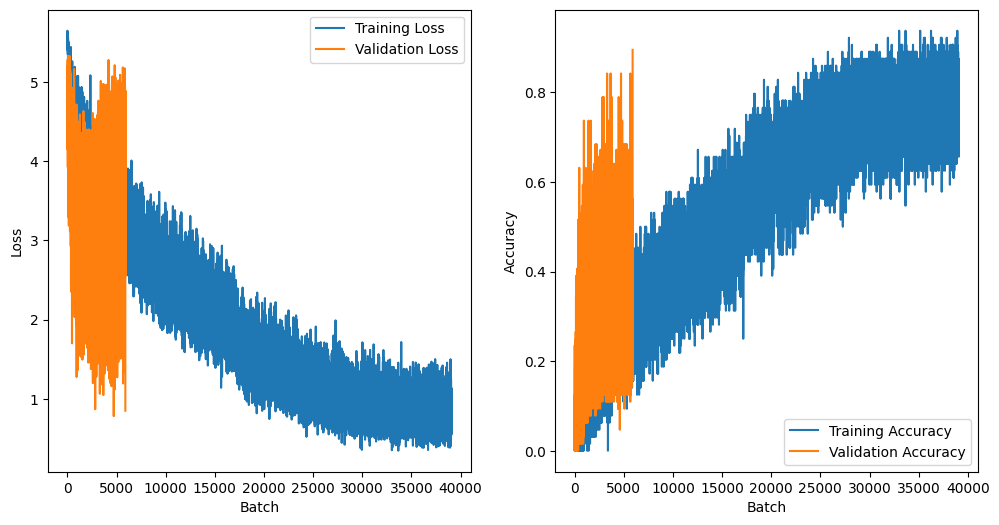

In [ ]:
#plot losses and accuracies
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(training_per_batch_losses, label='Training Loss')
plt.plot(validation_per_batch_losses, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(training_per_batch_accuracies, label='Training Accuracy')
plt.plot(validation_per_batch_accuracies, label='Validation Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
cnn.train()
images, labels = next(iter(train_dataloader))
images, labels = images.to(device), labels.to(device)

for i in range(200):
    optimizer.zero_grad()
    outputs = cnn(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    print(f"[{i}] Loss: {loss.item()}")


NameError: name 'optimizer' is not defined

In [14]:
# count the number of images per class in reduced train df
reduced_train_df['label'].value_counts().sort_index()

# count the number of classes that have lower than 350 samples
reduced_train_df['label'].value_counts().sort_index()[reduced_train_df['label'].value_counts().sort_index() < 350].count()


np.int64(81)

In [15]:
best_model = ResidualFoodCNN(num_classes=251)
best_model.load_state_dict(torch.load('food_classification_model350.pth'))
best_model.to(device)
best_model.eval()

ResidualFoodCNN(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
  )
  (layer1): Sequential(
    (0): ResidualDWBlock(
      (main): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
        (3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): SEBlock(
          (pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=128, out_features=8, bias=True)
            (1): SiLU()
            (2): Linear(in_features=8, out_features=128, bias=True)
            (3): Sigmoid()
          )
        )
      )
      (skip): Sequentia

In [16]:
# Accuracy, F1Score, Precision, Recall
accuracy = Accuracy(num_classes=251, task='multiclass').to(device)

f1_macro = F1Score(num_classes=251, task='multiclass', average='macro').to(device)
f1_weighted = F1Score(num_classes=251, task='multiclass', average='weighted').to(device)

precision_macro = Precision(num_classes=251, task='multiclass', average='macro').to(device)
precision_weighted = Precision(num_classes=251, task='multiclass', average='weighted').to(device)

recall_macro = Recall(num_classes=251, task='multiclass', average='macro').to(device)
recall_weighted = Recall(num_classes=251, task='multiclass', average='weighted').to(device)

with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)

        # Compute metrics
        accuracy(outputs, labels)
        f1_macro(outputs, labels)
        f1_weighted(outputs, labels)
        precision_macro(outputs, labels)
        precision_weighted(outputs, labels)
        recall_macro(outputs, labels)
        recall_weighted(outputs, labels)  

# Print metrics
print(f"Accuracy: {accuracy.compute().item() * 100:.2f}%")
print(f"F1 Score (Macro): {f1_macro.compute().item()* 100:.2f}%")
print(f"F1 Score (Weighted): {f1_weighted.compute().item()* 100:.2f}%")
print(f"Precision (Macro): {precision_macro.compute().item()* 100:.2f}%")
print(f"Precision (Weighted): {precision_weighted.compute().item()* 100:.2f}%")
print(f"Recall (Macro): {recall_macro.compute().item()* 100:.2f}%")

  0%|          | 0/188 [00:00<?, ?it/s]

 10%|█         | 19/188 [00:14<02:07,  1.32it/s]


KeyboardInterrupt: 

# SelfSupervisedLearning

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6505601..1.541961].


Text(0.5, 1.0, 'Jigsaw Image')

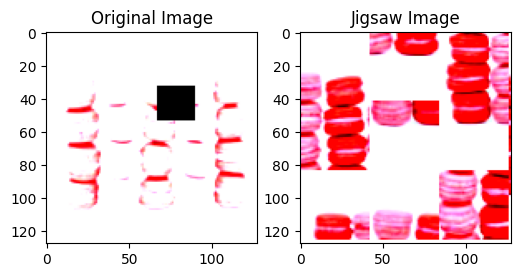

In [10]:
import random

# https://github.com/kalelpark/FG-SSL/blob/main/utils/setting.py#L46
def jigsaw_generator(images, n):
    l = []
    for a in range(n):
        for b in range(n):
            l.append([a, b])
    
    block_size = 128 // n
    rounds = n ** 2
    random.shuffle(l)
    jigsaws = images.clone()

    for i in range(rounds):
        x, y = l[i]
        temp = jigsaws[..., 0 : block_size, 0 : block_size].clone()
        jigsaws[..., 0:block_size, 0:block_size] = jigsaws[..., x * block_size : (x+1) * block_size,
                                                    y*block_size : (y +1) * block_size].clone()
        jigsaws[..., x * block_size: (x + 1) * block_size, y * block_size : (y + 1) * block_size] = temp

    return jigsaws

jigsaw = jigsaw_generator(train_dataset.__getitem__(0)[0].unsqueeze(0), 3)
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(train_dataset.__getitem__(0)[0].permute(1, 2, 0).numpy())
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(jigsaw.squeeze(0).permute(1, 2, 0).numpy())
plt.title("Jigsaw Image")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.490719..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141

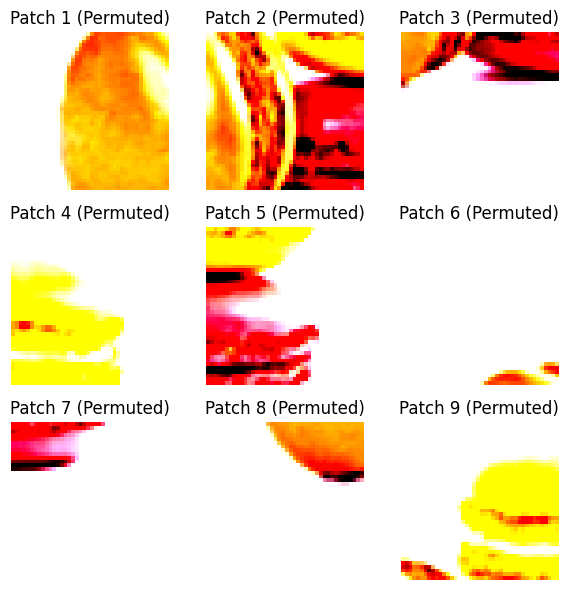

In [11]:
import itertools
from scipy.spatial.distance import pdist, squareform

def generate_diverse_permutations(n_patches, n_permutations, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    # Generate all possible permutations
    all_perms = list(itertools.permutations(range(n_patches)))

    # Randomly sample a subset to reduce computational cost
    sample_size = min(5000, len(all_perms))  # cap for speed
    sampled_perms = random.sample(all_perms, sample_size)

    # Compute Hamming distance matrix between all sampled permutations
    perm_array = np.array(sampled_perms)
    dists = squareform(pdist(perm_array, metric='hamming'))

    # Greedy selection of diverse permutations
    selected = [0]
    for _ in range(1, n_permutations):
        # Find the permutation that is farthest from the already selected ones
        remaining = list(set(range(len(perm_array))) - set(selected))
        min_dist = [min(dists[i][selected]) for i in remaining]
        next_idx = remaining[np.argmax(min_dist)]
        selected.append(next_idx)

    diverse_perms = [tuple(perm_array[i]) for i in selected]
    return diverse_perms

perm_set = generate_diverse_permutations(n_patches=9, n_permutations=100, seed=42)

def jigsaw_puzzle_patches(image, grid_size=3, perm_set=None):
    """
    Given an image, return permuted patches and the permutation index.
    
    Args:
        image (Tensor): (C, H, W)
        grid_size (int): number of grid divisions per side (default: 3)
        perm_set (List[List[int]]): list of permutations (length N^2 each)
        
    Returns:
        patch_tensor: (N, C, h, w) permuted patches
        perm_index: int in [0, len(perm_set)-1]
    """
    C, H, W = image.shape
    patch_h, patch_w = H // grid_size, W // grid_size
    N = grid_size * grid_size

    # Step 1: extract patches (C, h, w) each
    patches = []
    for i in range(grid_size):
        for j in range(grid_size):
            top = i * patch_h
            left = j * patch_w
            patch = image[:, top:top + patch_h, left:left + patch_w]
            patches.append(patch)

    # Stack into tensor (N, C, h, w)
    patches = torch.stack(patches, dim=0)

    # Step 2: pick random permutation
    if perm_set is None:
        perm_set = [list(range(N))]  # default identity
    perm_index = random.randint(0, len(perm_set) - 1)
    perm = perm_set[perm_index]

    # Step 3: permute patches
    permuted_patches = [patches[i] for i in perm]

    return permuted_patches, perm_index

# Example usage
image = train_dataset.__getitem__(7)[0]
permuted_patches, perm_index = jigsaw_puzzle_patches(image, grid_size=3, perm_set=perm_set)
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(permuted_patches[i].permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.title(f"Patch {i+1} (Permuted)")
plt.tight_layout()  


In [12]:
import pickle 

with open('./perms.pkl', 'wb') as f:
    pickle.dump(perm_set, f)


In [13]:
class JigsawDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, grid_size=3, perm_set=None):
        self.dataset = dataset
        self.grid_size = grid_size
        self.perm_set = perm_set

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        permuted_patches, perm_index = jigsaw_puzzle_patches(image, self.grid_size, self.perm_set)

        # Convert patches to a single image since the cnn expects a single image input
        jigsaw_image = torch.cat([torch.cat(permuted_patches[i:i + self.grid_size], dim=1) for i in range(0, len(permuted_patches), self.grid_size)], dim=2)

        return jigsaw_image, perm_index

    
jigsaw_dataset_train = JigsawDataset(train_dataset, grid_size=3, perm_set=perm_set)
jigsaw_dataset_val = JigsawDataset(val_dataset, grid_size=3, perm_set=perm_set)

jigsaw_train_dataloader = torch.utils.data.DataLoader(jigsaw_dataset_train, batch_size=64, shuffle=True)
jigsaw_val_dataloader = torch.utils.data.DataLoader(jigsaw_dataset_val, batch_size=64, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].


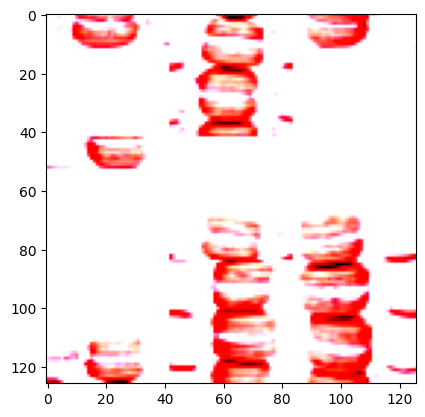

In [14]:
jigsaw_dataset_train.__getitem__(0)[0]
plt.imshow(jigsaw_dataset_train.__getitem__(0)[0].permute(1, 2, 0).cpu().numpy())

In [16]:
self_model = ResidualFoodCNN(num_classes=100)
self_model.to(device)

num_epochs = 20
optimizer = torch.optim.AdamW(self_model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

shutil.rmtree('runs/food_classification', ignore_errors=True)
writer = SummaryWriter('runs/food_classification')

training_accuracy = torchmetrics.Accuracy(num_classes=100, task='multiclass').to(device)
validation_accuracy = torchmetrics.Accuracy(num_classes=100, task='multiclass').to(device)
criterion = nn.CrossEntropyLoss().to(device)

training_per_batch_losses = []
training_per_batch_accuracies = []
validation_per_batch_losses = []
validation_per_batch_accuracies = []

for epoch in range(num_epochs):


    self_model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(tqdm(jigsaw_train_dataloader)):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = self_model(images)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        training_per_batch_losses.append(loss.item())
        training_per_batch_accuracies.append(training_accuracy(outputs, labels).item())

        # Logging
        writer.add_scalar('Loss/train', loss.item(), epoch * len(jigsaw_train_dataloader) + i)

    # Compute and print epoch-level training metrics
    avg_train_loss = sum(training_per_batch_losses[-len(jigsaw_train_dataloader):]) / len(jigsaw_train_dataloader)
    avg_train_acc = sum(training_per_batch_accuracies[-len(jigsaw_train_dataloader):]) / len(jigsaw_train_dataloader)
    print(f"[Epoch {epoch+1}] Training Loss: {avg_train_loss:.4f} | Training Accuracy: {avg_train_acc*100:.2f}%")

    # 🔍 Validation
    self_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(jigsaw_val_dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = self_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            validation_per_batch_losses.append(loss.item())
            validation_per_batch_accuracies.append(validation_accuracy(outputs, labels).item())

    avg_val_loss = sum(validation_per_batch_losses[-len(jigsaw_val_dataloader):]) / len(jigsaw_val_dataloader)
    avg_val_acc = sum(validation_per_batch_accuracies[-len(jigsaw_val_dataloader):]) / len(jigsaw_val_dataloader)
    print(f"[Epoch {epoch+1}] Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_acc*100:.2f}%")

    scheduler.step(avg_val_loss)


100%|██████████| 1314/1314 [09:41<00:00,  2.26it/s]


[Epoch 1] Training Loss: 2.4163 | Training Accuracy: 40.70%


100%|██████████| 118/118 [01:22<00:00,  1.44it/s]


[Epoch 1] Validation Loss: 0.8623 | Validation Accuracy: 76.58%


100%|██████████| 1314/1314 [14:36<00:00,  1.50it/s]


[Epoch 2] Training Loss: 0.6239 | Training Accuracy: 83.23%


100%|██████████| 118/118 [01:38<00:00,  1.20it/s]


[Epoch 2] Validation Loss: 0.4551 | Validation Accuracy: 87.36%


100%|██████████| 1314/1314 [18:46<00:00,  1.17it/s]


[Epoch 3] Training Loss: 0.4179 | Training Accuracy: 88.65%


100%|██████████| 118/118 [01:47<00:00,  1.10it/s]


[Epoch 3] Validation Loss: 0.3599 | Validation Accuracy: 89.75%


100%|██████████| 1314/1314 [18:54<00:00,  1.16it/s]


[Epoch 4] Training Loss: 0.3354 | Training Accuracy: 90.96%


100%|██████████| 118/118 [01:40<00:00,  1.17it/s]


[Epoch 4] Validation Loss: 0.2574 | Validation Accuracy: 92.98%


 23%|██▎       | 302/1314 [03:58<13:19,  1.27it/s]


KeyboardInterrupt: 